# Development of new features for polymerist

In [ ]:
import networkx as nx
from rdkit import Chem

import mbuild
from mbuild.compound import Compound
from mbuild.conversion import load, load_smiles, from_rdkit, to_smiles, to_pybel
from mbuild.lib.recipes.polymer import Polymer

comp = mbuild.Compound()

## Developing monomer graphs

### String/graph translation (SMILES-like)

In [ ]:
from typing import ClassVar, Generator, Optional, Sequence, Union
from itertools import product as cartesian_product

from polymerist.genutils.iteration import asiterable
from polymerist.genutils.sequences import bin_ids_forming_sequence
from polymerist.genutils.textual.delimiters import validate_braces 


class MonomerGraph(nx.Graph):
    '''A graph representation of the connectivity of monomer fragments in a polymer topology'''
    MONOMER_NAME_ATTR : ClassVar[str] = 'monomer_name' # node attribute name to assign the name of each monomer to

    # connectivity properties
    @property
    def num_monomers(self) -> int:
        '''Number of monomer units represented in the current polymer'''
        return self.number_of_nodes()
    DOP = num_monomers

    @property
    def is_unbranched(self) -> bool:
        '''Whether the monomer graph represents straight chain(s) without branching'''
        return all(node_deg <= 2 for node_id, node_deg in self.degree)
    is_linear = is_unbranched

    @property
    def is_unbranched(self) -> bool:
        '''Whether the monomer graph represents straight chain(s) without branching'''
        return not self.is_unbranched
    

    # topological and multi-chain settings
    @property
    def num_chains(self) -> int:
        '''The number of disconnected chains represented by the MonoGraph'''
        return nx.number_connected_components(self)

    @property
    def chains(self) -> Generator['MonomerGraph', None, None]:
        '''Generates all disconnected polymers chains in the graph sequentially'''
        for cc_nodes in nx.connected_components(self):
            yield self.subgraph(cc_nodes)

    @property
    def unique_monomer_names(self) -> set[str]:
        '''The collection of unique monomer names embedded in the graph nodes'''
        return set(nx.get_node_attributes(self, self.MONOMER_NAME_ATTR).values())


    # visualization
    def draw(self, show_names : bool=True) -> None: # TODO: expand arg passing (positions, matplotlib axes, etc)
        '''Visualize graph structure with NetworkX'''
        labels = nx.get_node_attributes(self, self.MONOMER_NAME_ATTR) if show_names else None
        nx.draw(self, with_labels=True, labels=labels)
    visualize = draw


    # chemical information checks
    def insert_chemical_info(self, chemical_info : dict[str, dict]) -> None:
        '''Insert SMILES, SMARTS, and atom/linker count info into nodes from minimal set of monomer info templates'''
        raise NotImplemented

    def _validate(self) -> bool:
        '''Check whether the chemical information inserted into the monomer graph is valid'''
        raise NotImplemented


    # SMILES-like in-line encodings
    ## Reading string
    @classmethod
    def from_smidge_string(cls, monostring : str, start_node_idx : int=0) -> 'MonomerGraph':
        '''Parse a SMIDGE ("SMILES-like Monomer Interconnectivity & Degree Graph Encoding") string and read it into a networkX Graph'''
        validate_braces(monostring) # check that all braces are in order before proceeding
        visited : list[int] = []
        curr_idx = start_node_idx - 1
        mononame = ''
        
        monograph = cls() # create empty instance with class initializer
        for char in monostring:
            if char == '[':                                 # 1) if reached a new monomer block...
                mononame = ''                               #   clear the current monomer name
                curr_idx += 1                               #   and advance the current position index
            elif char == ']':                               # 2) if reached the end of a monomer block...
                monograph.add_node(curr_idx, **{cls.MONOMER_NAME_ATTR : mononame}) #   add a new node with the current index and name
                if visited:                                 #   if previously-visited nodes exist...
                    monograph.add_edge(curr_idx, visited.pop())     #   remove the last visited node from the traversal stack and link the current node to it
                visited.append(curr_idx)                    #   add the current node to the stack of visited nodes
            elif char == '(':                               # 3) if beginning a traversal branch...
                visited.append(visited[-1])                 #   duplicate the last visited node
            elif char == ')':                               # 4) if exiting a branch...
                visited.pop()                               #   remove the last visited position and return to the previous most recent visited node
            elif char == '.':                               # 5) if reaching the end of a connected component... | TOSELF: opted for this over str.split('.') as this already tracks node sequence
                visited.clear()                             #   clear the visited stack to restart the traversal for the new component (ensures it is not connected to the previous one)
            else:                                           # 6) otherwise... 
                mononame += char                            #   must be inside a monomer block; in that case, just extend the current name
            
        return monograph
    from_SMIDGE = from_smidge = from_smidge_string

    ## Writing string
    def _validate_start_node_idxs(self : nx.Graph, start_node_idxs : Optional[Union[int, Sequence[int]]]=None) -> dict[int, int]:
        '''Check if a collection of DFS traversal start indices are valid for the current graph topology'''
        # 0) if explicitly NO ids are passed, no validation is needed
        n_chains = self.num_chains
        if start_node_idxs is None:
            return {
                i : min(chain) # assign the smallest node in each component as the starting indices
                    for i, chain in enumerate(self.chains)
            }

        # 1) check that there are enough start nodes for the present number of chains
        start_node_idxs = asiterable(start_node_idxs) # convert to iterable to handle singleton values in a unified way
        n_nodes = len(start_node_idxs)
        if n_nodes != n_chains:
            quantifier = 'few' if (n_nodes < n_chains) else 'many'
            raise ValueError(f'Provided too {quantifier} chain start indices traversal of the given graph ({n_nodes} provided for {n_chains}-chain graph)')

        # 2) check that there exists a 1:1 mapping between the provided node collection and DISTINCT connected components
        possible_cc_orders = bin_ids_forming_sequence(start_node_idxs, nx.connected_components(self), unique_bins=True)
        try:
            cc_order = next(possible_cc_orders)
            return {
                chain_idx : start_node_idx
                    for (chain_idx, start_node_idx) in zip(cc_order, start_node_idxs) # the parity of this is guaranteed by the prior length match check
        }
        except StopIteration:
            raise ValueError('Starting node indices provided do not uniquely correspond to distinct chains')

    def _chain_to_smidge_string(self : nx.Graph, start_node_idx : Optional[int]=None) -> str:
        '''Convert an individual chain in monomer graph into a SMIDGE ("SMILES-like Monomer Interconnectivity & Degree Graph Encoding") string'''
        neighbors = nx.dfs_successors(self, source=start_node_idx) # determine DFS ordering of nodes and their neighbors
        visited = {i : False for i in self.nodes} 
        stack = [start_node_idx]
        
        tokens = []
        while stack:
            curr_idx = stack.pop()
            if not visited[curr_idx]:                                   # 1) collect appropriate tokens for the current node, depending on whether it has already been visited
                mononame = self.nodes[curr_idx][self.MONOMER_NAME_ATTR] # get the name associated with the current monomer node (enclosed in square brackets)
                tokens.append(f'[{mononame}]')                          #   push the current node's monomer label onto the result stack
                visited[curr_idx] = True                                #   and mark as having been visited
            else:                                                       # otherwise, if returning to an already-visited node...
                tokens.append(')')                                      #   close the branch that must have led to this node
                
            if (successors := neighbors.get(curr_idx, [])):             # 2) get the remaining DFS successors of the current node, proceeding with checks if nonempty...
                if (len(successors) > 1):                               # if multiple unvisited successors are present...
                    tokens.append('(')                                  #   initialize a new branch point indicator 
                    stack.append(curr_idx)                              #   and mark the current node 
                stack.append(successors.pop(0))                         # push the first available successor node to be visited next

        return ''.join(tokens)
    
    def to_smidge_string(self : nx.Graph, start_node_idxs :  Optional[Union[int, Sequence[int]]]=None) -> str:
        '''Convert a monomer graph into a SMIDGE ("SMILES-like Monomer Interconnectivity & Degree Graph Encoding") string'''
        chain_starts = self._validate_start_node_idxs(start_node_idxs)
        return '.'.join(
            self._chain_to_smidge_string(start_node_idx=chain_starts[i])
                for i in range(self.num_chains)
        )
    to_smidge = to_SMIDGE = to_smidge_string

    ## Testing string translation
    def _passes_string_conversion_tests(self) -> tuple[bool, Optional[tuple[int]]]:
        '''Developer function, tests if conversion to and from graph strings preserves the graph topology invariant to the starting node
        Returns a bool of whether test passes for all possible traversal starting positions, and tuple of positions of first failure (or None if passing)'''
        for start_idxs in cartesian_product(*[chain.nodes for chain in self.chains]):
            isostr = self.to_smidge_string(start_node_idxs=start_idxs)
            isograph = self.from_smidge_string(isostr)
            if not nx.is_isomorphic(self, isograph):
                return False, start_idxs
        else:
            return True, None
MonoGraph = MonomerGraph # alias for convenience

In [100]:
from string import ascii_uppercase

test1 = '[a][A]([A])[B][A]([A][B]([A][A])[B][C])[A][C][b]'
test2 = test1.replace('A', 'A2').replace('B', 'B2').replace('a', 'A1').replace('b', 'B1').replace('C', 'OTHER')
test3 = 'AB(CD)EFG(H(I)J)K(L)M'#(DD)CC'
# test3 = 'EFG(H(I)J)K(L)M'#(DD)CC'
test4 = 'ABC(D(E)F)G(H)I'#(DD)CC'
test5 = 'ABCD'
test6 = 'A(B)(C)(D)E(F)(G)(H)I(J)(K)L'
for char in ascii_uppercase:
    test3 = test3.replace(char, f'[{char}]')
    test4 = test4.replace(char, f'[{char}]')
    test5 = test5.replace(char, f'[{char}]')
    test6 = test6.replace(char, f'[{char}]')
tests = [
    test1,
    test2,
    test3,
    test4,
    test5,
    test6
]

targ_str = f'{tests[-2]}.{tests[-1]}'
# targ_str = tests[0]
print(targ_str)
print('\n'.join(tests))

[A][B][C][D].[A]([B])([C])([D])[E]([F])([G])([H])[I]([J])([K])[L]
[a][A]([A])[B][A]([A][B]([A][A])[B][C])[A][C][b]
[A1][A2]([A2])[B2][A2]([A2][B2]([A2][A2])[B2][OTHER])[A2][OTHER][B1]
[A][B]([C][D])[E][F][G]([H]([I])[J])[K]([L])[M]
[A][B][C]([D]([E])[F])[G]([H])[I]
[A][B][C][D]
[A]([B])([C])([D])[E]([F])([G])([H])[I]([J])([K])[L]


In [ ]:
# from polymerist.polymers.monographs import MonomerGraph, MonomerGraphSerializer

G = MonomerGraph.from_smidge(targ_str)
G.visualize(show_names=True)

In [ ]:
res = G.to_smidge(start_node_idxs=(0,13))
print(res, '\n', targ_str)

H = MonomerGraph.from_smidge(res)
# nx.draw(H, with_labels=True)
nx.draw(H, with_labels=True, labels=nx.get_node_attributes(H, H.MONOMER_NAME_ATTR))

In [ ]:
for i, bt in Chem.BondType.values.items():
    print(i, bt)

In [ ]:
G._passes_string_conversion_tests()

### Refining the SMIDGE parser

In [129]:
import re
from rdkit import Chem

from typing import ClassVar, Union, Optional
from dataclasses import dataclass, field
from polymerist.rdutils.smileslib.primitives import RDKIT_BONDS_BY_BONDTYPE, BONDTYPE_BY_BOND_SMILES


# PROCESSING BOND TOKENS IN SMIDGE STRINGS
BOND_PRIMITIVES_FOR_RE = '[~\-=#$:]' # any of the SMARTS bond primitive chars, with an espace reserved for the single-bond hyphen as range char in RE
BOND_TOKEN_RE = re.compile(
    r'(?P<incoming_flavor>\d*)' \
    f'(?P<bondtype>{BOND_PRIMITIVES_FOR_RE})' \
    r'(?P<outgoing_flavor>\d*)'
)

@dataclass
class MonomerGraphBondInfo:
    '''Encapsulated information about an intermonomer bond in a monomer graph'''
    DEFAULT_BONDTYPE : ClassVar[Chem.BondType] = Chem.BondType.UNSPECIFIED, 
    DEFAULT_FLAVOR   : ClassVar[int] = 0

    incoming_flavor : int    = field(default=DEFAULT_FLAVOR)
    bondtype : Chem.BondType = field(default=DEFAULT_BONDTYPE)
    outgoing_flavor : int    = field(default=DEFAULT_FLAVOR)

    def __post_init__(self) -> None:
        '''Perform appropriate type conversions and apply defaults'''
        if self.incoming_flavor is None:
            self.incoming_flavor = self.DEFAULT_FLAVOR

        if self.bondtype is None:
            self.bondtype = self.DEFAULT_BONDTYPE

        if self.outgoing_flavor is None:
            self.outgoing_flavor = self.DEFAULT_FLAVOR

    @staticmethod
    def parse_str_dict(str_dict : dict[str, str]) -> dict[str, Optional[Union[str, Chem.BondType]]]:
        '''Parse string-valued dict into dict of correct types and NoneType defaults for empty keys'''
        # 0) create copy of dict to avoid any in-place modification
        imb_info = {k : v for k, v in str_dict.items()}
        
        # 1) process bond type
        imb_info['bondtype'] = BONDTYPE_BY_BOND_SMILES.get(imb_info.get('bondtype')) # set to None either if no bondtype is provided OR the provided type is not a registered primitive

        # 2) process port flavors
        for flavor_attr in ('incoming_flavor', 'outgoing_flavor'):
            if not (flavor_str := imb_info.get(flavor_attr)): # raised when the flavor_str is either not present or empty
                imb_info[flavor_attr] = None
            elif isinstance(flavor_str, str) and flavor_str.isdigit():
                imb_info[flavor_attr] = int(flavor_str) # convert parsed strings to ints where possible

        return imb_info

    @classmethod
    def from_dict(cls, str_dict : dict[str, str]) -> 'MonomerGraphBondInfo':
        '''Initialize from dictionary of values, after sanitizing'''
        return cls(**cls.parse_str_dict(str_dict))

    @classmethod
    def from_match(cls, match : Optional[re.Match]) -> 'MonomerGraphBondInfo':
        '''Initialize from groupdict of regex Match'''
        if match is None:
            return cls()
        return cls.from_dict(match.groupdict())

In [159]:
from abc import ABC, abstractmethod, abstractproperty, abstractclassmethod
from polymerist.genutils.textual.delimiters import validate_braces
from polymerist.polymers.monographs import MonomerGraph


# STATE BASE
class SMIDGEParserState(ABC):
    @property
    def parser(self) -> 'SMIDGEParser':
        return self._smidge_parser
    
    @abstractmethod
    def state_action(self, inputs : str) -> None:
        pass

    # @abstractmethod
    # def transition(self, values) -> 'SMIDGEParserState':
    #     pass

# CONCRETE STATES
class Accumulate(SMIDGEParserState):
    '''Collect characters into a buffer'''
    def state_action(self, inputs : str) -> None:
        self.parser.str_buffer += inputs

class ChainNew(SMIDGEParserState):
    '''Reset actions when beginning a new chain'''
    def state_action(self, inputs: str) -> None:
        self.parser.node_stack.clear()

class MonomerStart(SMIDGEParserState):
    '''Begin reading in a new monomer'''
    def state_action(self, inputs: str) -> None:
        self.parser.str_buffer = ''
        self.parser.curr_idx += 1

class MonomerEnd(SMIDGEParserState):
    '''Finish reading a monomer and add it to the graph'''
    def state_action(self, inputs: str) -> None:
        self.parser.monograph.add_node(
            self.parser.curr_idx,
            **{
                MonomerGraph.MONOMER_NAME_ATTR : self.parser.str_buffer,
                'neighbor_flavors' : {}
            }
        ) #   add a new node with the current index and name
        
        if self.parser.node_stack: # if previously-node_stack nodes exist...
            curr_node_id = self.parser.curr_idx
            prev_node_id = self.parser.node_stack.pop() # remove the last node_stack node from the traversal stack
            self.parser.monograph.nodes[prev_node_id]['neighbor_flavors'][curr_node_id] = self.parser.bond_info.incoming_flavor
            self.parser.monograph.nodes[curr_node_id]['neighbor_flavors'][prev_node_id] = self.parser.bond_info.outgoing_flavor

            self.parser.monograph.add_edge(prev_node_id, curr_node_id, bondtype=self.parser.bond_info.bondtype) # link the current node to it, with appropriate bond type
            print(self.parser.bond_info)
        self.parser.node_stack.append(self.parser.curr_idx) # add the current node to the stack of node_stack nodes

class BondStart(SMIDGEParserState):
    '''Initialize reading of a bond token'''
    def state_action(self, inputs: str) -> None:
        self.parser.str_buffer = ''

class BondEnd(SMIDGEParserState):
    def state_action(self, inputs: str) -> None:
        self.parser.bond_info = MonomerGraphBondInfo.from_match(re.match(BOND_TOKEN_RE, self.parser.str_buffer))

class BranchStart(SMIDGEParserState):
    '''Mark position of branch point in stack for backtrack'''
    def state_action(self, inputs: str) -> None:
        self.parser.node_stack.append(self.parser.node_stack[-1])

class BranchEnd(SMIDGEParserState):
    '''Return to previous branch point'''
    def state_action(self, inputs: str) -> None:
        self.parser.node_stack.pop() # remove the last node_stack position and return to the previous most recent node_stack node
        

# PARSER
@dataclass
class SMIDGEParser:
    '''Finite state machine for parsing SMIDGE strings into monomer graphs'''
    monograph : Optional[MonomerGraph] = field(default=None) # this is the only initializable field
    
    curr_idx   : int = field(default_factory=int , init=False)
    str_buffer : str = field(default_factory=str , init=False)
    node_stack : list[int] = field(default_factory=list, init=False)
    bond_info  : MonomerGraphBondInfo = field(default_factory=MonomerGraphBondInfo, init=False)

    state : SMIDGEParserState = field(default_factory=ChainNew, init=False) # initial state is always the new chain state

    STATEMAP : ClassVar[dict[str, SMIDGEParserState]] = {
        '.' : ChainNew(),
        '[' : MonomerStart(),
        ']' : MonomerEnd(),
        '(' : BranchStart(),
        ')' : BranchEnd(),
        '{' : BondStart(),
        '}' : BondEnd(),
    }

    def read_smidge(self, smidge_string : str, start_node_idx : int=0) -> MonomerGraph:
        '''Parse a SMIDGE ("SMILES-like Monomer Interconnectivity & Degree Graph Encoding") string and read it into a networkX Graph'''
        validate_braces(smidge_string) # check that all braces are in order before proceeding
        self.curr_idx = start_node_idx - 1
        self.monograph = MonomerGraph() # clear out monomer graph for read

        for char in smidge_string:
            print(char, type(self.state).__name__, self.str_buffer, self.curr_idx)
            self.state = self.STATEMAP.get(char, Accumulate()) # default to Accumulate state
            self.state._smidge_parser = self
            self.state.state_action(char)

        return self.monograph
            

In [160]:
# test = f'{tests[-2]}.{tests[-2]}'
test = '[a]{-1}[A]({2-3}[B]{2=5}[C]{5=2}[B]{3-6}[b])({2-3}[B]({3-6}[b]){3-}[a]){-}[A]{2-2}[B]{3-6}[b]'
test

'[a]{-1}[A]({2-3}[B]{2=5}[C]{5=2}[B]{3-6}[b])({2-3}[B]({3-6}[b]){3-}[a]){-}[A]{2-2}[B]{3-6}[b]'

In [161]:
parser = SMIDGEParser()
G = parser.read_smidge(test)

[ ChainNew  -1
a MonomerStart  0
] Accumulate a 0
{ MonomerEnd a 0
- BondStart  0
1 Accumulate - 0
} Accumulate -1 0
[ BondEnd -1 0
A MonomerStart  1
] Accumulate A 1
MonomerGraphBondInfo(incoming_flavor=0, bondtype=rdkit.Chem.rdchem.BondType.SINGLE, outgoing_flavor=1)
( MonomerEnd A 1
{ BranchStart A 1
2 BondStart  1
- Accumulate 2 1
3 Accumulate 2- 1
} Accumulate 2-3 1
[ BondEnd 2-3 1
B MonomerStart  2
] Accumulate B 2
MonomerGraphBondInfo(incoming_flavor=2, bondtype=rdkit.Chem.rdchem.BondType.SINGLE, outgoing_flavor=3)
{ MonomerEnd B 2
2 BondStart  2
= Accumulate 2 2
5 Accumulate 2= 2
} Accumulate 2=5 2
[ BondEnd 2=5 2
C MonomerStart  3
] Accumulate C 3
MonomerGraphBondInfo(incoming_flavor=2, bondtype=rdkit.Chem.rdchem.BondType.DOUBLE, outgoing_flavor=5)
{ MonomerEnd C 3
5 BondStart  3
= Accumulate 5 3
2 Accumulate 5= 3
} Accumulate 5=2 3
[ BondEnd 5=2 3
B MonomerStart  4
] Accumulate B 4
MonomerGraphBondInfo(incoming_flavor=5, bondtype=rdkit.Chem.rdchem.BondType.DOUBLE, outgoing_fl

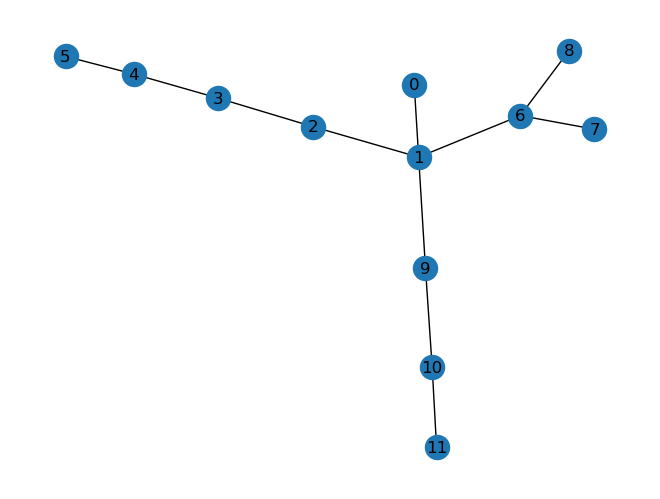

In [162]:
G.visualize(show_names=False)

### "Alphabet" of monomer fragment chemical information 

In [ ]:
from typing import Optional
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from dataclasses import dataclass, field


from polymerist.genutils.fileutils.jsonio.serialize import JSONSerializable, TypeSerializer, MultiTypeSerializer
from polymerist.genutils.fileutils.jsonio.jsonify import make_jsonifiable, JSONifiable
from polymerist.polymers.monographs import MonomerGraph, MonomerGraphSerializer
from polymerist.rdutils.bonding.portlib import get_num_linkers


@dataclass
class MonomerFragmentInfo:
    '''Naming and in-line chemical encodings for a monomer unit within a polymer chain'''
    name   : str
    smiles : str
    smarts   : Optional[str] = field(default=None)
    category : Optional[str] = field(default=None)

    n_atoms       : int = field(init=False)
    functionality : int = field(init=False)
    contribution  : int = field(init=False)

    def __post_init__(self) -> None:
        tempmol = self.rdmol
        self.n_atoms = tempmol.GetNumAtoms()
        self.functionality = get_num_linkers(tempmol)
        self.contribution = self.n_atoms - self.functionality

    @property
    def rdmol(self) -> Chem.Mol:
        return Chem.MolFromSmiles(self.smiles, sanitize=False)

class MonomerFragmentInfoSerializer(TypeSerializer):
    python_type = MonomerFragmentInfo

    @staticmethod
    def encode(python_obj : MonomerFragmentInfo) -> dict[str, JSONSerializable]:
        return python_obj.__dict__

    @staticmethod
    def decode(json_obj : dict[str, JSONSerializable]) -> MonomerFragmentInfo:
        params = {k : v for k, v in json_obj.items() if k not in ('n_atoms', 'functionality', 'contribution')}
        return MonomerFragmentInfo(**params)

PolymerStructureSerializer = MultiTypeSerializer(MonomerGraphSerializer, MonomerFragmentInfoSerializer)
@make_jsonifiable(type_serializer=PolymerStructureSerializer)
@dataclass
class PolymerStructure:
    '''Encodes a multi-scale structural representation of a polymer topology'''
    monoinfo  : dict[str, MonomerFragmentInfo]
    monograph : MonomerGraph

    @property
    def node_info_map(self) -> dict[int, MonomerFragmentInfo]:
        '''Map from node indices to relevant monomer information'''
        return {
            node_id : self.monoinfo[alias]
                for node_id, alias in nx.get_node_attributes(self.monograph, self.monograph.MONOMER_NAME_ATTR).items()
        }

    def chem_info_is_compatible(self) -> bool:
        '''Validate whether the chemical information for monomer fragments is compatible with the structural graph'''
        if set(self.monoinfo.keys()) != self.monograph.unique_monomer_names:
            return False
        
        for node_id, degree in self.monograph.degree:
            if (degree != self.node_info_map[node_id].functionality):
                return False
        
        return True

In [ ]:
from string import ascii_uppercase 
from polymerist.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_ports


parent_monomers = {
    'ethane-1,2-diol' : 'OCCO',
    'furan-2,5-dicarboxylic acid' : 'O=C(O)c1ccc(C(=O)O)o1',
}
monomer_aliases = {
    mononame : lett
        for mononame, lett in zip(parent_monomers.keys(), ascii_uppercase)
}

monogrp = MonomerGroup.from_file('poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic acid).json')
moldict, monosmiles = {}, {}
for mononame, rdmol in monogrp.iter_rdmols():
    for i, port in enumerate(get_ports(rdmol)):
        rdmol.GetAtomWithIdx(port.linker.GetIdx()).SetIsotope(i)

    print(mononame)
    display(rdmol)
    moldict[   mononame] = rdmol
    monosmiles[mononame] = Chem.MolToSmiles(rdmol)

In [ ]:
from polymerist.monomers import specification

mono_infos = {}
for mononame, smiles in monosmiles.items():
    parent_mononame = mononame.split('_')[0]
    parent_smiles = parent_monomers[parent_mononame]
    parent_alias  = monomer_aliases[parent_mononame]

    mono_info = MonomerFragmentInfo(
        name=mononame,
        smiles=smiles,
        smarts=specification.compliant_mol_SMARTS(smiles),
        category=parent_smiles,
    )
    alias = parent_alias.lower() if (mono_info.functionality == 1) else parent_alias.upper()
    mono_infos[alias] = mono_info
mono_infos

In [ ]:
import networkx as nx
from polymerist.genutils.textual import delimiters
from polymerist.polymers.monographs import MonomerGraph


smidge = delimiters.square_brackets_around_letters('aBABABAb')
monograph = MonomerGraph.from_smidge(smidge)
monograph.draw()

poly = PolymerStructure(
    monoinfo=mono_infos,
    monograph=monograph
)

In [ ]:
poly.to_file('test.json')

In [ ]:
p = PolymerStructure.from_file('test.json')

In [ ]:
p.monograph.draw()

In [ ]:
poly.chem_info_is_compatible()